In [1]:
from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns
%matplotlib inline

In [2]:
colnames=['ip', 'timestamp', 'request_method', 'status', 'size',
          'destination', 'request_agent']
df_orig = pd.read_csv('http://python.zach.lol/access.log',          
                 engine='python',
                 header=None,
                 index_col=False,
                 names=colnames,
                 sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                 na_values='"-"',
                 usecols=[0, 3, 4, 5, 6, 7, 8]
)

new = pd.DataFrame([["95.31.18.119", "[21/Apr/2019:10:02:41+0000]", 
                     "GET /api/v1/items/HTTP/1.1", 200, 1153005, np.nan, 
                     "python-requests/2.21.0"],
                    ["95.31.16.121", "[17/Apr/2019:19:36:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 1005, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.15.120", "[18/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 2560, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.19.58", "[19/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 200, 2056327, np.nan, 
                     "python-requests/2.21.0"]], columns=colnames)

df = df_orig.append(new)

In [3]:
df.head()

,ip,timestamp,request_method,status,size,destination,request_agent
0,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
1,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""
2,97.105.19.58,[16/Apr/2019:19:34:44 +0000],"""GET /api/v1/sales?page=82 HTTP/1.1""",200,510103,NaN,"""python-requests/2.21.0"""
3,97.105.19.58,[16/Apr/2019:19:34:46 +0000],"""GET /api/v1/sales?page=83 HTTP/1.1""",200,510003,NaN,"""python-requests/2.21.0"""
4,97.105.19.58,[16/Apr/2019:19:34:48 +0000],"""GET /api/v1/sales?page=84 HTTP/1.1""",200,511963,NaN,"""python-requests/2.21.0"""


In [4]:
df.timestamp = df.timestamp.str.replace(r'(\[|\])', '', regex=True)
df.timestamp= pd.to_datetime(df.timestamp.str.replace(':', ' ', 1)) 
df['timestamp'] = df['timestamp'].astype(str).str[:-6]
df = df.set_index('timestamp')

In [5]:
df.head()

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-16 19:34:42,97.105.19.58,"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:42,97.105.19.58,"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:44,97.105.19.58,"""GET /api/v1/sales?page=82 HTTP/1.1""",200,510103,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:46,97.105.19.58,"""GET /api/v1/sales?page=83 HTTP/1.1""",200,510003,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:48,97.105.19.58,"""GET /api/v1/sales?page=84 HTTP/1.1""",200,511963,NaN,"""python-requests/2.21.0"""


In [6]:
for col in ['request_method', 'request_agent', 'destination']:
    df[col] = df[col].str.replace('"', '')

df['request_method'] = df.request_method.str.replace(r'\?page=[0-9]+', '', regex=True)

df.head()

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,NaN,python-requests/2.21.0
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,NaN,python-requests/2.21.0
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,NaN,python-requests/2.21.0
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,NaN,python-requests/2.21.0


In [7]:
df['size_mb'] = [n/1024/1024 for n in df['size']]

In [8]:
ip_df = pd.DataFrame(df.ip.value_counts(dropna=False)).reset_index().\
                rename(index=str, columns={'index': 'ip', 'ip': 'ip_count'})
ip_df2 = pd.DataFrame(df.ip.value_counts(dropna=False)/df.ip.count()).reset_index().\
                rename(index=str, columns={'index': 'ip', 'ip': 'ip_proba'})
ip_df = ip_df.merge(ip_df2)


# see those where rate < 1% 
ip_df[ip_df.ip_proba < .01]

,ip,ip_count,ip_proba
4,68.201.219.223,21,0.001502
5,24.26.242.9,21,0.001502
6,35.175.171.137,2,0.000143
7,52.87.230.102,2,0.000143
8,70.121.214.34,2,0.000143
9,3.92.201.136,1,0.000072
10,52.90.165.200,1,0.000072
11,35.174.209.2,1,0.000072
12,3.88.129.158,1,0.000072
13,95.31.18.119,1,0.000072


22
               ip  ip_count  ip_proba
12   3.88.129.158         1  0.000072
13   95.31.18.119         1  0.000072
14  34.229.70.250         1  0.000072
15  54.145.52.184         1  0.000072
16  34.207.64.242         1  0.000072
17  97.105.15.120         1  0.000072
18   52.91.30.150         1  0.000072
19   95.31.16.121         1  0.000072
20  54.172.14.223         1  0.000072
21   45.23.250.16         1  0.000072


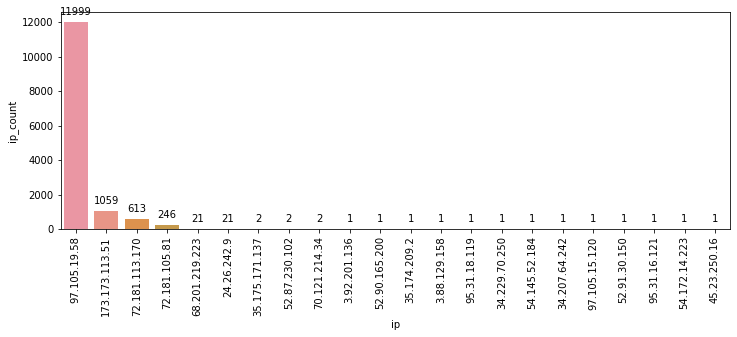

In [9]:
print(len(ip_df))

print(ip_df.tail(10))

plt.figure(figsize=(12, 4))
splot = sns.barplot(data=ip_df, x = 'ip', y = 'ip_count', ci = None)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 10), 
                   textcoords = 'offset points'
                   )
    plt.xticks(rotation='vertical')

In [10]:
train = df['2019-04-16 19:34:42':'2019-04-17 12:55:14'][['ip','request_method','status','size','destination','request_agent','size_mb']]